# Clustering and Regression Analysis
During our hypothesis testing, we validated our observations from the exploratory data analysis. In this section we will conduct regression analyisis to quantify the effects of each variables on the log-charges of premiums of the insured. To conduct inference, we will be using linear regression model. To make good inference, we must first check if our data and our model follows the assumptions of linear regression model.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASET_URI = "dataset/insurance.csv"
df0 = pd.read_csv(DATASET_URI)

## Feature Transformation

In [3]:
# Engineer Features
df0["log-charges"] = np.log1p(df0["charges"])
df0.drop(["charges"], axis=1, inplace=True)

df0.sample(n=10)

,age,sex,bmi,children,smoker,region,log-charges
1057,45,female,31.790,0,no,southeast,9.794247
274,25,male,27.550,0,no,northwest,7.833667
391,19,female,37.430,0,no,northwest,7.668127
288,59,female,36.765,1,yes,northeast,10.776825
1047,22,male,52.580,1,yes,southeast,10.703298
492,18,female,25.080,0,no,northeast,7.695063
664,64,female,22.990,0,yes,southeast,10.205032
655,52,female,25.300,2,yes,southeast,10.113279
671,29,female,31.160,0,no,northeast,8.280102
835,42,male,35.970,2,no,southeast,8.876451


In [4]:
df1 = pd.get_dummies(df0, drop_first=True)

## Data Visualization
Let's visualize the distribution of the numerical predictors with the response variables.

In [5]:
sns.set_style("whitegrid")

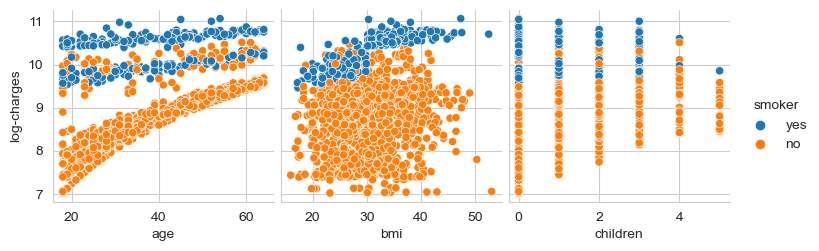

In [6]:
sns.pairplot(
    df0,
    kind="scatter",
    hue="smoker",
    x_vars=["age", "bmi", "children"],
    y_vars=["log-charges"],
);

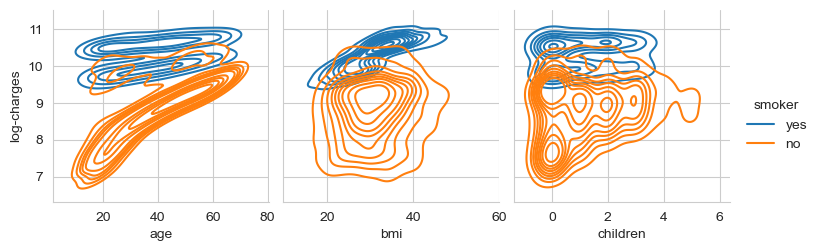

In [7]:
sns.pairplot(
    df0,
    kind="kde",
    hue="smoker",
    x_vars=["age", "bmi", "children"],
    y_vars=["log-charges"]
);

Based on the above results, the relationship of `age`, `bmi`, and `children` with `log-charges` is not linear. Using the bivariate kernel density plot, we can observe that there were several clusters present on our dataset. Let's examine our dataset further if we can find subgroups/clusters. One way we could do this is using `FacetGrid` of seaborn.
Using this chart, we can visualize more than two variables.

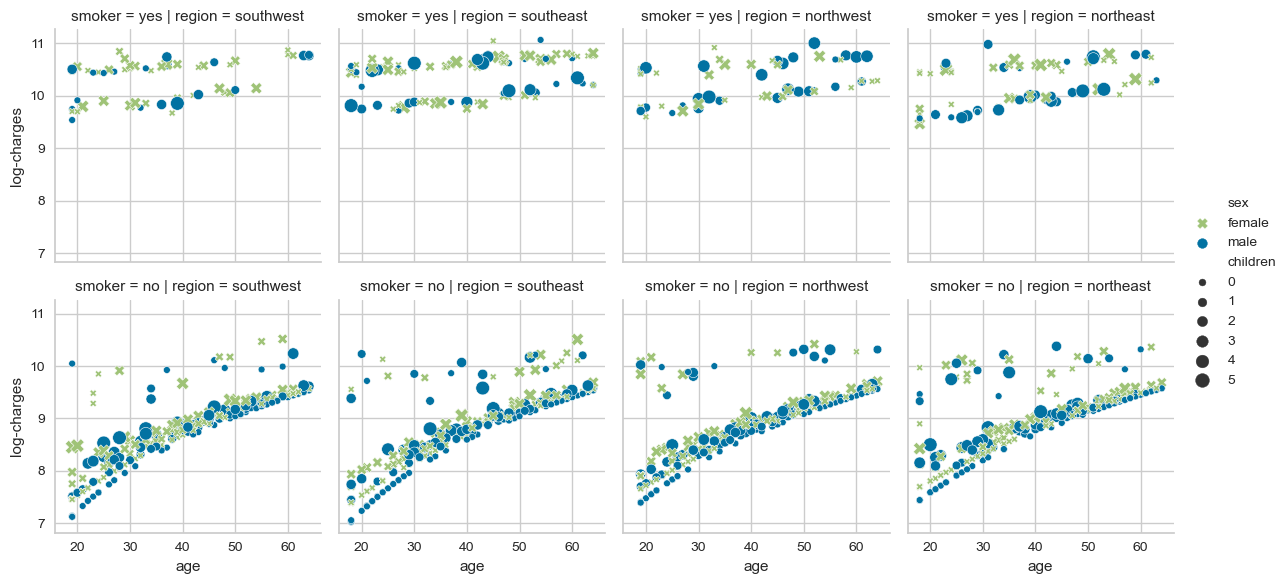

In [22]:
g = sns.FacetGrid(df0, col="region",  row="smoker")
g.map(sns.scatterplot, "age", "log-charges", "sex", "children", "sex");
g.add_legend()

On the above visualization, we plotted the scatterplot of age and log-charges. We can observe that the shape of the distribution of smokers and non-smokers were different! The scatterplot of smokers contains two clusters with a pattern similar to that of a line. On the same manner, the scatterplot of non-smokers also contains two clusters. However, one its cluster appears to be a quadratic line while the other appears to be a straight line with some noise.

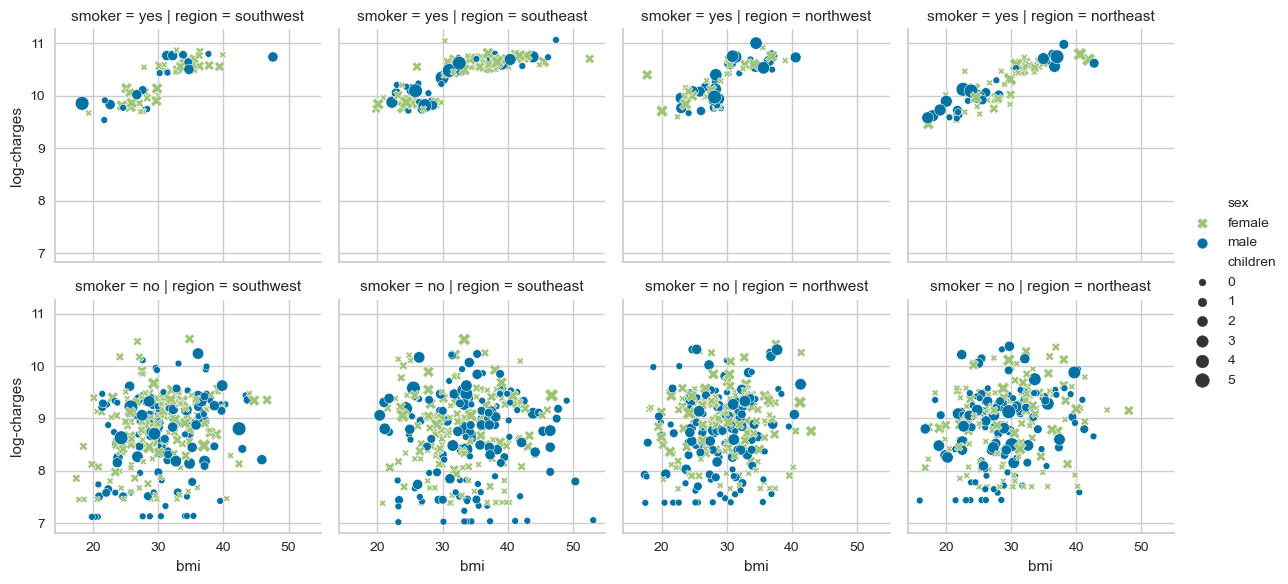

In [21]:
g = sns.FacetGrid(df0, col="region",  row="smoker")
g.map(sns.scatterplot, "bmi", "log-charges", "sex", "children", "sex");
g.add_legend()

The above visualization shows the scatter plot of `bmi` with `log-charges`. On the above plot, we can observe that the distribution of non-smokers and smokers were very different. The scatterplot of smokers appears to be a straight line whereas for the non-smoker, no pattern can be observed.

Based on our observations from our exploratory data analysis, we cannot proceed yet with linear regression modelling. There were no direct linear relationship between our numerical variables. In addition, we observed presence of subgroups in our scatter plots. Before conducting a regression analysis, let's cluster our dataset using unsupervised machine learning. Once clustered, we will conduct separate regression analysis on each cluster.

## Clustering
During our data visualization, we observed that there were 6-different clusters of data. To make a more accurate clustering, we can use K-Means clustering algorithm instead.

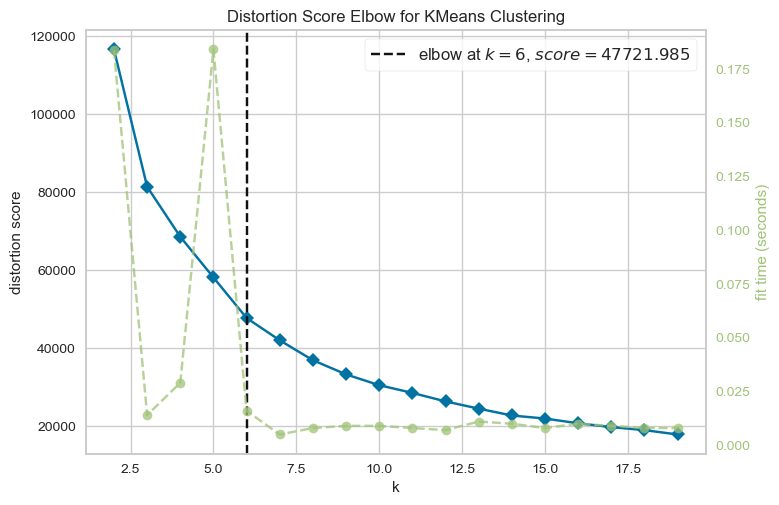

In [10]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

elbow_visualizer = KElbowVisualizer(KMeans(random_state=22), k=(2,20))
elbow_visualizer.fit(df1)
elbow_visualizer.show();

The above visualization shows the amount of distortion score as the number of cluster increases. Based on the above plot, the optimal number of cluster for our dataset was 6. Surprisingly, this finding was the same with our observations from our data visualization.

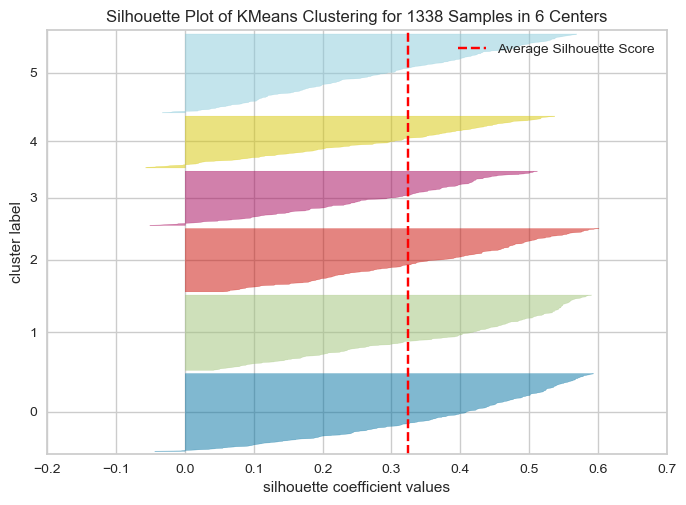

In [11]:
from yellowbrick.cluster import SilhouetteVisualizer

silhouette_visualizer = SilhouetteVisualizer(KMeans(elbow_visualizer.elbow_value_, random_state=22), colors='yellowbrick')
silhouette_visualizer.fit(df1)
silhouette_visualizer.show();

Above silhouette plot shows that all of the 6 clusters had an above average silhouette scores. This means that our dataset can be clustered into 6 different groups.

### Cluster the Dataframe

In [15]:
clusterer = KMeans(n_clusters=elbow_visualizer.elbow_value_, random_state=42)

clusterer.fit(df1)

KMeans(n_clusters=6, random_state=42)

In [16]:
df0["cluster"] = clusterer.labels_
df0.sample(10)

,age,sex,bmi,children,smoker,region,log-charges,cluster
225,55,male,33.880,3,no,southeast,9.391675,2
196,39,female,32.800,0,no,southwest,8.639537,4
563,50,male,44.770,1,no,southeast,9.111595,3
205,28,female,28.880,1,no,northeast,8.375338,4
60,43,male,27.360,3,no,northeast,9.060356,0
582,39,male,45.430,2,no,southeast,8.757354,3
386,58,female,39.050,0,no,southeast,9.380708,2
91,53,female,24.795,1,no,northwest,9.300467,0
1242,22,female,21.280,3,no,northwest,8.365735,1
305,29,male,33.345,2,no,northwest,9.875261,5


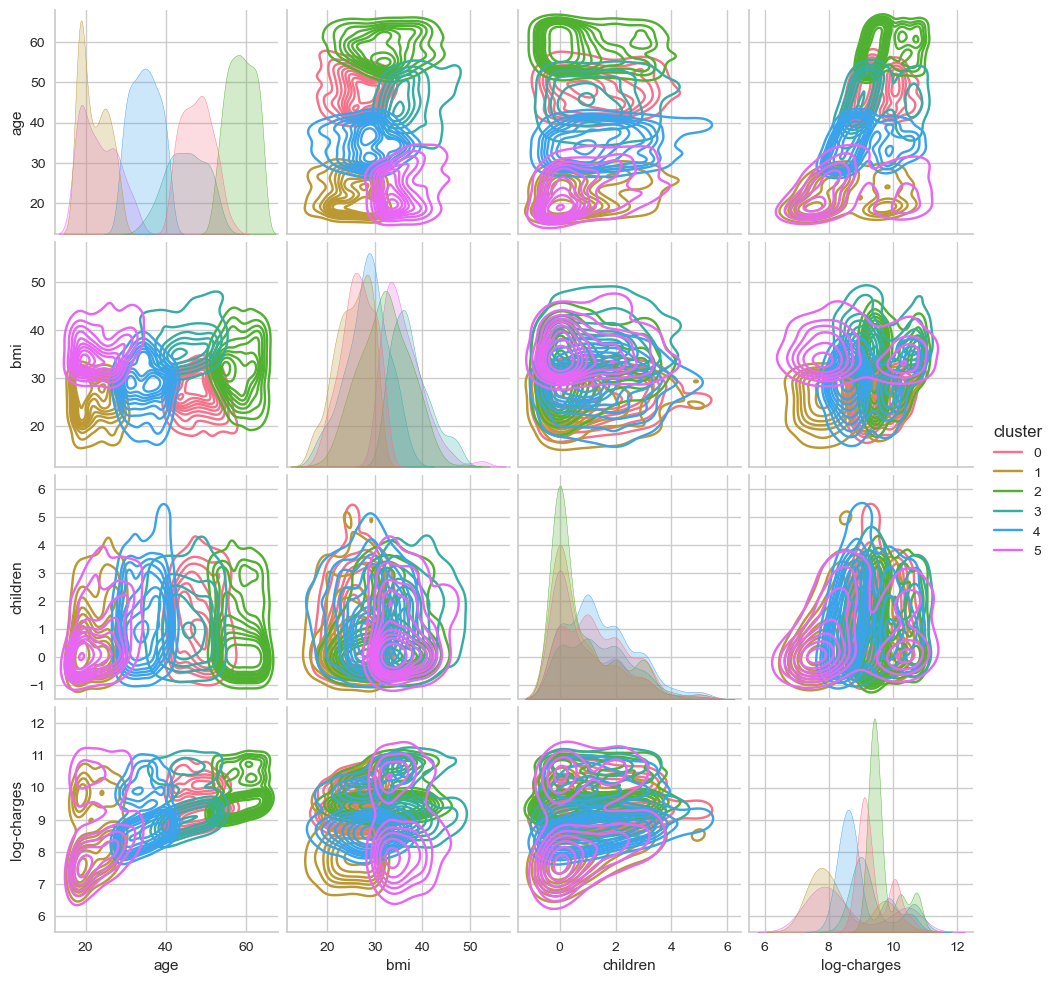

In [17]:
sns.pairplot(
    df0,
    kind="kde",
    hue="cluster",
    palette=sns.color_palette("husl", elbow_visualizer.elbow_value_),
);

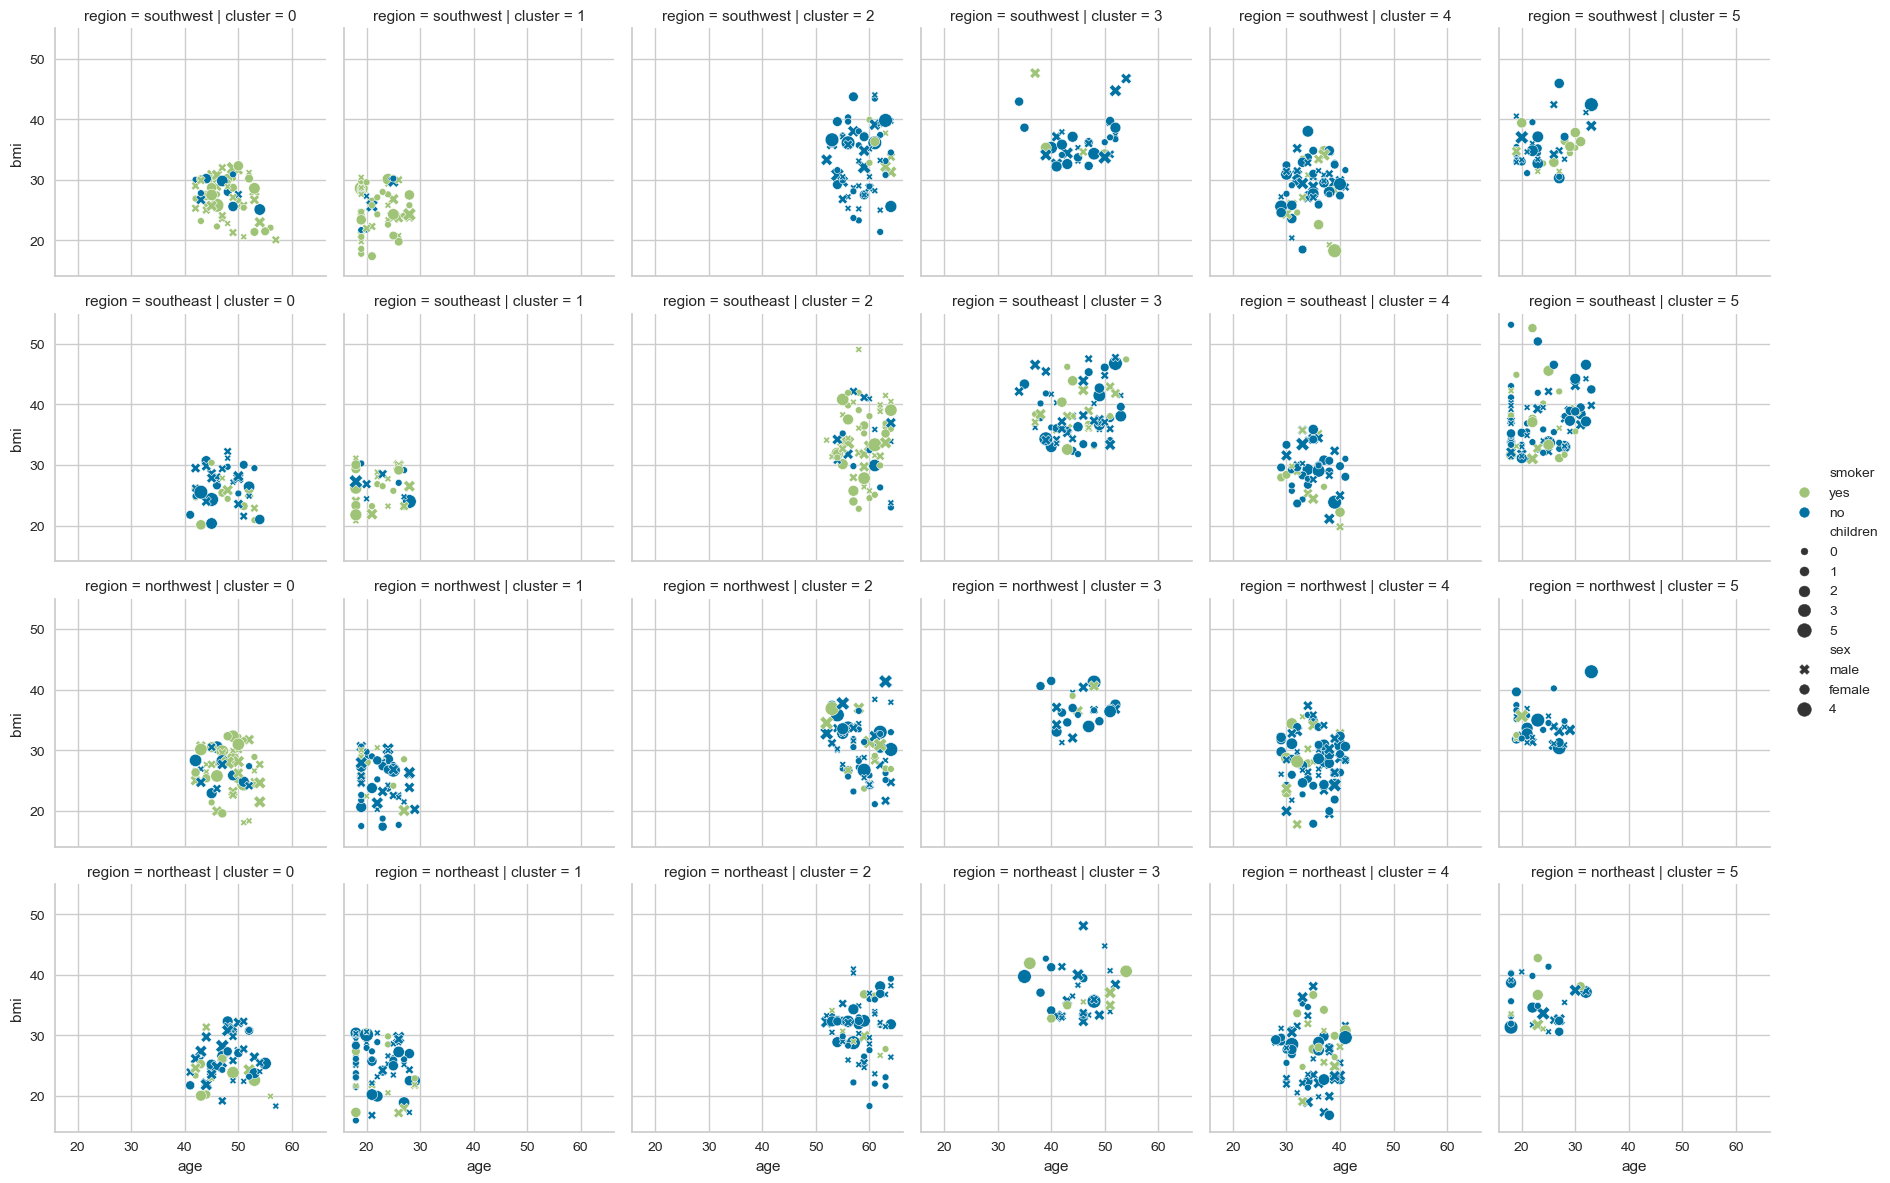

In [29]:
g = sns.FacetGrid(df0, col="cluster",  row="region")
g.map(sns.scatterplot, "age", "bmi", "smoker", "children", "sex");
g.add_legend();